In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

%matplotlib inline
import matplotlib.pylab as plt

In [19]:
import ld_gan
from time import time
import numpy as np
from tqdm import tqdm
from ld_gan import visualize

In [3]:
X, Y = ld_gan.data_proc.data_loader.load_data(1, verbose=1, resize = 64)

100%|██████████| 102/102 [00:19<00:00,  7.79it/s]

load data from '/export/home/oblum/projects/ls_gan/data/flowers_102/jpg_128'


In [4]:
enc = ld_gan.utils.model_handler.load_model("xf_11111_s10l.py", 650, "enc")
gen = ld_gan.utils.model_handler.load_model("xf_11111_s10l.py", 650, "gen")
dis = ld_gan.utils.model_handler.load_model("xf_11111_s10l.py", 650, "dis")

/net/hciserver03/storage/oblum/venvs/compvisgpu02/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'ld_gan.models.enc.Enc' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/net/hciserver03/storage/oblum/venvs/compvisgpu02/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'ld_gan.models.gen.Gen' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


loaded model 'projects/xf_11111_s10l.py/model/e_0650.pth'
loaded model 'projects/xf_11111_s10l.py/model/g_0650.pth'
loaded model 'projects/xf_11111_s10l.py/model/d_0650.pth'


/net/hciserver03/storage/oblum/venvs/compvisgpu02/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'ld_gan.models.dis.Dis' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
z_enc = ld_gan.utils.model_handler.apply_model(enc, X)

In [6]:
from ld_gan.train_ops.triplet_enc import generate_triplets

In [7]:
ancs = z_enc[:256]

In [9]:
from ld_gan.utils.model_handler import apply_models

In [10]:
def get_dis_score(z1, z2):
    factors = np.linspace(0,1,8)
    zs = [z1*f + z2*(1-f) for f in factors]
    ds = []
    for z in zs:
        ds.append(apply_models(z, None, gen, dis))
    ds = np.array(ds)
    scores = np.min(ds, axis=0)
    return scores

# hyperparameter n_candidates

In [11]:
n_cand = [10, 20, 40, 80]
mean_factor = []
std_factor = []
times = []

for nc in tqdm(n_cand):

    t = time()
    anchors, zs_pos, zs_neg = generate_triplets(gen, dis, ancs, z_enc, 7, nc)
    t = time() - t
    
    times.append(t)
    
    pos_scores = get_dis_score(anchors, zs_pos)
    neg_scores = get_dis_score(anchors, zs_neg)
    factor = pos_scores / neg_scores
    mean_factor.append(factor.mean())
    std_factor.append(factor.std())
    print nc, ":", factor.mean(), "+-", factor.std()

 25%|██▌       | 1/4 [00:04<00:14,  5.00s/it]

10 : 2.42418 +- 5.0622
20

 50%|█████     | 2/4 [00:14<00:12,  6.20s/it]

 : 3.01931 +- 10.0411
40

 75%|███████▌  | 3/4 [00:31<00:09,  9.51s/it]

 : 3.33592 +- 8.07596
80

100%|██████████| 4/4 [01:06<00:00, 17.30s/it]

 : 2.54933 +- 4.83591


[]

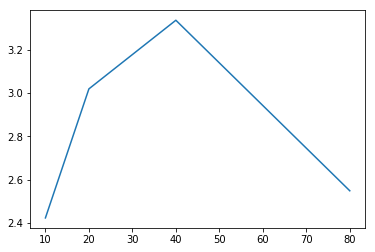

In [12]:
plt.figure()
plt.plot(n_cand, mean_factor)
#plt.errorbar(n_cand, mean_factor, yerr=std_factor)
plt.plot()

# view images

In [13]:
ancs = X[:256]

In [26]:
t = time()
anchors, xs_pos, xs_neg = generate_triplets(enc, gen, dis, ancs, X, 7, 10)
time() - t

5.06618595123291

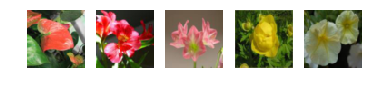

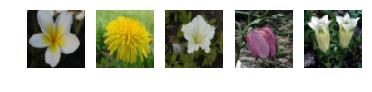

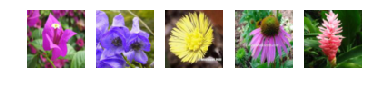

In [27]:
visualize.disp(anchors[:5])
visualize.disp(xs_pos[:5])
visualize.disp(xs_neg[:5])